## **Setting up the environment**


#**Final Project Digital Image Processing**
##Signature Forgery Detection
######Fariz Muhammad
######Katarina Keishanti J. K.
######Ramzy Izza Wardhana

###Dataset:
https://drive.google.com/drive/folders/1PUcCvHuVI54IZWOx6QXmd3ZH8gFTc9Vp

1. Importing Libraries as needed

In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage
from skimage.measure import regionprops
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage import io
from skimage.filters import threshold_otsu, prewitt_h, prewitt_v
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
import numpy as np
from time import time
import keras
import cv2
import glob
tf.compat.v1.disable_eager_execution()


2. Mounting the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
genuine_image_paths = "/content/drive/MyDrive/revdataset/train/genuine"
forged_image_paths = "/content/drive/MyDrive/revdataset/train/forged"
test_image = "/content/drive/MyDrive/revdataset/test"
img_path = os.path.join(test_image, '*')
img_path = glob.glob(img_path)

3. Verifying that the data is properly loaded

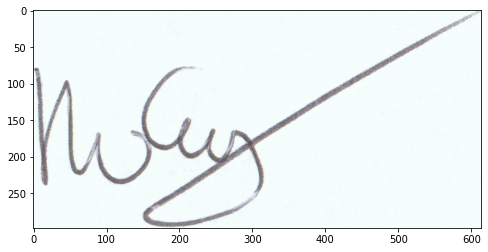

In [ ]:
image = io.imread(img_path[0])

i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

## **Image Enhancement**

1. Reduce the noise from the greyscale

In [ ]:
def noisereduction(img):
   noiseReduction = cv2.fastNlMeansDenoising(img, None, 20, 7, 21)
   return noiseReduction

2. Converts RGB to greyscale

In [ ]:
def rgbToGreyscale(img):
    img = noisereduction(img)
    grey = np.zeros((img.shape[0], img.shape[1]))
    for x in range(len(img)):
        for y in range(len(img[x])):
            grey[x][y] = np.average(img[x][y])
    return grey

3. Sharpen the greyscale image

    In here, we used the commonly used kernel to sharpen the image.
    
    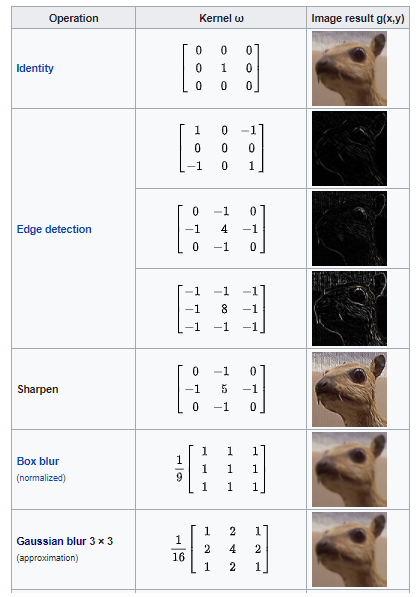
    

In [ ]:
def sharpen(img):
  img = rgbToGreyscale(img)
  kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
  sharpenImage = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
  return(sharpenImage)

## **Image Segmentation**

1. Otsu Method

    *NOTE: OTSU method (OTSU) is a global adaptive binarization threshold image segmentation algorithm.

In [ ]:
def otsu(img):
    img = sharpen(img)
    thres = threshold_otsu(img)
    binaryImage = img > thres
    binaryImage = np.logical_not(binaryImage)
    return binaryImage

## **Display the images:**

  *   Normal image
  *   Noise reduced image
  *   Greyscale image
  *   Sharpened greyscale image
  *   Binary greyscale image using OTSU binarization segmentation
  *   Binary greyscale image with only the needed features



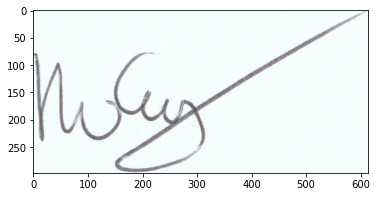

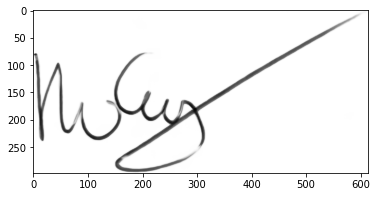

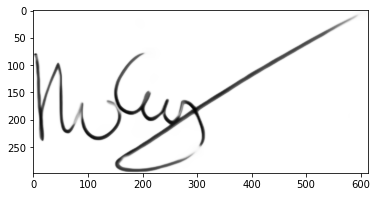

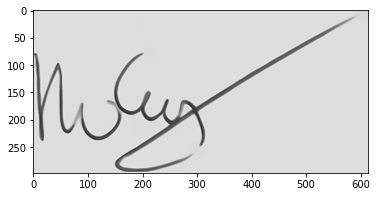

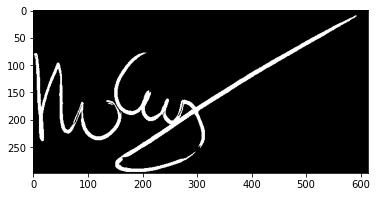

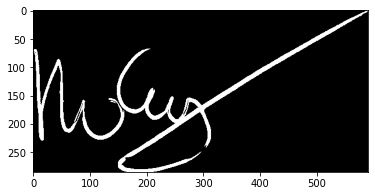

array([[False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
def preproc(img, display=True):
    if display:
      # Display Original Image
        plt.imshow(img)
        plt.show()
    grey = rgbToGreyscale(img)
    if display:
      # Display Greyscale Image
        plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
        plt.show()
    grey2 = np.uint8(grey)
    noise = noisereduction(grey2)
    if display:
        # Display Greyscale + Denoised Image
        plt.imshow(noise, cmap = matplotlib.cm.Greys_r)
        plt.show()
    sharpened = sharpen(noise)
    sharpened1 = np.uint8(sharpened)
    if display:
        # Display Greyscale + Denoised  + Sharpen Image
        plt.imshow(sharpened, cmap = matplotlib.cm.Greys_r)
        plt.show()
    binimg = otsu(img)
    if display:
       # Display Segmentation of enhanced image
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    r, c = np.where(binimg==1)
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    return signimg

preproc(image)

## **Image Feature Extraction**

In [ ]:
def Size(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total
Size(image)

ValueError: ignored

In [ ]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [ ]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

In [ ]:
def caclEccentricity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity

In [ ]:
def calcSolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].solidity

In [ ]:
def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

In [ ]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)
    y = range(h)

    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)

    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)

    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))


    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)


    x4 = (x-cx)**4
    y4 = (y-cy)**4

    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

In [ ]:
def averageScore(path, img=None, display=False):
    if img is None:
        img = io.imread(path)
    img = preproc(img, display=display)
    size = Size(img)
    centroid = calcCentroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = calcSkewnessAndKurtosis(img)
    average = (size + centroid + eccentricity + solidity + skewness + kurtosis) / 5
    return average

In [ ]:
def getFeatures(path, img=None, display=False):
    if img is None:
        img = io.imread(path)
    img = preproc(img, display=display)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

In [ ]:
def getCSVFeatures(path, img=None, display=False):
    if img is None:
        img = io.imread(path)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

In [ ]:
def makeCSV():
    if not(os.path.exists('/content/drive/MyDrive/Features')):
        os.mkdir('/content/drive/MyDrive/Features')
        print('New folder "Features" created')
    if not(os.path.exists('/content/drive/MyDrive/Features/Training')):
        os.mkdir('/content/drive/MyDrive/Features/Training')
        print('New folder "Features/Training" created')
    if not(os.path.exists('/content/drive/MyDrive/Features/Testing')):
        os.mkdir('/content/drive/MyDrive/Features/Testing')
        print('New folder "Features/Testing" created')

    gpath = genuine_image_paths

    fpath = forged_image_paths
    for person in range(1,64):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)

        with open('/content/drive/MyDrive/Features/Training/training_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Training set
            for i in range(0,3):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.PNG')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(0,3):
                source = os.path.join(fpath, '999'+per+'_00'+str(i)+'.PNG')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')

        with open('/content/drive/MyDrive/Features/Testing/testing_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Testing set
            for i in range(3, 5):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.PNG')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(3,5):
                source = os.path.join(fpath, '999'+per+'_00'+str(i)+'.PNG')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')

In [ ]:
makeCSV()

In [ ]:
while True:pass

## **Image Classification**

In [ ]:
def testing(path):
    feature = getCSVFeatures(path)
    if not(os.path.exists('/content/drive/MyDrive/TestFeatures')):
        os.mkdir('/content/drive/MyDrive/TestFeatures')
    with open('/content/drive/MyDrive/TestFeatures/testcsv.csv', 'w') as handle:
        handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y\n')
        handle.write(','.join(map(str, feature))+'\n')

In [ ]:
n_input = 9
train_person_id = input("Enter person's id : ")
test_image_path = input("Enter path of signature image : ")
train_path = '/content/drive/MyDrive/Features/Training/training_'+train_person_id+'.csv'
testing(test_image_path)
test_path = '/content/drive/MyDrive/TestFeatures/testcsv.csv'

def readCSV(train_path, test_path, type2=False):
    # Reading train data
    df = pd.read_csv(train_path, usecols=range(n_input))
    train_input = np.array(df.values)
    train_input = train_input.astype(np.float32, copy=False)  # Converting input to float_32
    df = pd.read_csv(train_path, usecols=(n_input,))
    temp = [elem[0] for elem in df.values]
    correct = np.array(temp)
    corr_train = keras.utils.to_categorical(correct,2)      # Converting to one hot
    # Reading test data
    df = pd.read_csv(test_path, usecols=range(n_input))
    test_input = np.array(df.values)
    test_input = test_input.astype(np.float32, copy=False)
    if not(type2):
        df = pd.read_csv(test_path, usecols=(n_input,))
        temp = [elem[0] for elem in df.values]
        correct = np.array(temp)
        corr_test = keras.utils.to_categorical(correct,2)      # Converting to one hot
    if not(type2):
        return train_input, corr_train, test_input, corr_test
    else:
        return train_input, corr_train, test_input

ops.reset_default_graph()
# Initialized Parameter
learning_rate = 0.001
training_epochs = 1000
display_step = 1
# Neural Network
n_hidden_1 = 7 # 1st layer Neurons
n_hidden_2 = 10 # 2nd layer Neurons
n_hidden_3 = 30 # 3rd layer Neurons
n_classes = 2 # Classes (Genuiene and Forged)

# Tensorflow Graph input
X = tf.compat.v1.placeholder("float", [None, n_input])
Y = tf.compat.v1.placeholder("float", [None, n_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.compat.v1.random_normal([n_input, n_hidden_1], seed=1)),
    'h2': tf.Variable(tf.compat.v1.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.compat.v1.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.compat.v1.random_normal([n_hidden_1, n_classes], seed=2))
}
biases = {
    'b1': tf.Variable(tf.compat.v1.random_normal([n_hidden_1], seed=3)),
    'b2': tf.Variable(tf.compat.v1.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.compat.v1.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.compat.v1.random_normal([n_classes], seed=4))
}

# Model Creation
def multilayerPerceptron(x):
    layer1 = tf.tanh((tf.matmul(x, weights['h1']) + biases['b1']))
    layer2 = tf.add(tf.matmul(layer1, weights['h2']), biases['b2'])
    layer3 = tf.add(tf.matmul(layer2, weights['h3']), biases['b3'])
    out_layer = tf.tanh(tf.matmul(layer1, weights['out']) + biases['out'])
    return out_layer

# Model Construction
logits = multilayerPerceptron(X)

# Loss and optimizer
loss_op = tf.reduce_mean(tf.math.squared_difference(logits, Y))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

pred = tf.nn.softmax(logits)  # Apply softmax to logits
correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Initializing the variables
init = tf.compat.v1.global_variables_initializer()

def evaluate(train_path, test_path, type2=False):
    if not(type2):
        train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)
    else:
        train_input, corr_train, test_input = readCSV(train_path, test_path, type2)
    ans = 'Random'
    with tf.compat.v1.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):
            _, cost = sess.run([train_op, loss_op], feed_dict={X: train_input, Y: corr_train})
            if cost<0.0001:
                break
        prediction = pred.eval({X: test_input})
        if prediction[0][1]>prediction[0][0]:
            print('Genuine Image')
            return True
        else:
            print('Forged Image')
            return False
evaluate(train_path, test_path, type2=True)

Enter person's id : 007
Enter path of signature image : /content/drive/MyDrive/revdataset/test/999007_005.PNG
Forged Image


False

In [ ]:
TP = 0
TN = 0
FP = 0
FN = 0

def readCSV(train_path, test_path, type2=False):
      # Reading train data
      df = pd.read_csv(train_path, usecols=range(n_input))
      train_input = np.array(df.values)
      train_input = train_input.astype(np.float32, copy=False)  # Converting input to float_32
      df = pd.read_csv(train_path, usecols=(n_input,))
      temp = [elem[0] for elem in df.values]
      correct = np.array(temp)
      corr_train = keras.utils.to_categorical(correct,2)      # Converting to one hot
      # Reading test data
      df = pd.read_csv(test_path, usecols=range(n_input))
      test_input = np.array(df.values)
      test_input = test_input.astype(np.float32, copy=False)
      if not(type2):
          df = pd.read_csv(test_path, usecols=(n_input,))
          temp = [elem[0] for elem in df.values]
          correct = np.array(temp)
          corr_test = keras.utils.to_categorical(correct,2)      # Converting to one hot
      if not(type2):
          return train_input, corr_train, test_inpu123t, corr_test
      else:
          return train_input, corr_train, test_input

for path in img_path:
  n_input = 9
  train_person_id = (path[path.find('_') + -3:path.find('_')])
  check = (path[path.find('_') + -6:path.find('_') + -3])
  test_image_path = path
  print(path)
  train_path = '/content/drive/MyDrive/Features/Training/training_'+train_person_id+'.csv'
  testing(test_image_path)123
  test_path = '/content/drive/MyDrive/TestFeatures/testcsv.csv'

  ops.reset_default_graph()
  # Parameters
  learning_rate = 0.001
  training_epochs = 1000
  display_step = 1

  # Network Parameters
  n_hidden_1 = 7 # 1st layer number of neurons
  n_hidden_2 = 10 # 2nd layer number of neurons
  n_hidden_3 = 30 # 3rd layer
  n_classes = 2 # no. of classes (genuine or forged)

  # tf Graph input
  X = tf.compat.v1.placeholder("float", [None, n_input])
  Y = tf.compat.v1.placeholder("float", [None, n_classes])

  # Store layers weight & bias
  weights = {
      'h1': tf.Variable(tf.compat.v1.random_normal([n_input, n_hidden_1], seed=1)),
      'h2': tf.Variable(tf.compat.v1.random_normal([n_hidden_1, n_hidden_2])),
      'h3': tf.Variable(tf.compat.v1.random_normal([n_hidden_2, n_hidden_3])),
      'out': tf.Variable(tf.compat.v1.random_normal([n_hidden_1, n_classes], seed=2))
  }
  biases = {
      'b1': tf.Variable(tf.compat.v1.random_normal([n_hidden_1], seed=3)),
      'b2': tf.Variable(tf.compat.v1.random_normal([n_hidden_2])),
      'b3': tf.Variable(tf.compat.v1.random_normal([n_hidden_3])),
      'out': tf.Variable(tf.compat.v1.random_normal([n_classes], seed=4))
  }


  # Create model
  def multilayer_perceptron(x):
      layer_1 = tf.tanh((tf.matmul(x, weights['h1']) + biases['b1']))
      layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
      layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
      out_layer = tf.tanh(tf.matmul(layer_1, weights['out']) + biases['out'])
      return out_layer

  # Construct model
  logits = multilayer_perceptron(X)

  # Define loss and optimizer

  loss_op = tf.reduce_mean(tf.math.squared_difference(logits, Y))
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(loss_op)
  # For accuracies
  pred = tf.nn.softmax(logits)  # Apply softmax to logits
  correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  # Initializing the variables
  init = tf.compat.v1.global_variables_initializer()

  def evaluate(train_path, test_path, type2=False):
      global TP, TN, FP, FN
      if not(type2):
          train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)
      else:
          train_input, corr_train, test_input = readCSV(train_path, test_path, type2)
      ans = 'Random'
      with tf.compat.v1.Session() as sess:
          sess.run(init)
          # Training cycle
          for epoch in range(training_epochs):
              # Run optimization op (backprop) and cost op (to get loss value)
              _, cost = sess.run([train_op, loss_op], feed_dict={X: train_input, Y: corr_train})
              if cost<0.0001:
                  break
  #             # Display logs per epoch step
  #             if epoch % 999 == 0:
  #                 print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(cost))
  #         print("Optimization Finished!")

          # Finding accuracies
          accuracy1 =  accuracy.eval({X: train_input, Y: corr_train})
          # print("Accuracy for train:", accuracy1)
  #         print("Accuracy for test:", accuracy2)
          if type2 is False:
              accuracy2 =  accuracy.eval({X: test_input, Y: corr_test})
              return accuracy1, accuracy2
          else:
              prediction = pred.eval({X: test_input})
              if prediction[0][1]>prediction[0][0]:
                  print('Genuine Image')
                  if(train_person_id == check):
                    TP = TP + 1
                  else:
                    FP = FP + 1
                  return True
              else:
                  print('Forged Image')
                  if(train_person_id == check):
                    FN = FN + 1
                  else:
                    TN = TN + 1
                  return False

  evaluate(train_path, test_path, type2=True)

print("True Pos: ", TP)
print("True Neg: ", TN)
print("False Pos: ", FP)
print("False Neg: ", FN)



/content/drive/MyDrive/revdataset/test/999001_008.PNG
Genuine Image
/content/drive/MyDrive/revdataset/test/002002_008.PNG
Forged Image
/content/drive/MyDrive/revdataset/test/999001_000.PNG
Genuine Image
/content/drive/MyDrive/revdataset/test/999002_001.PNG
Forged Image
/content/drive/MyDrive/revdataset/test/001001_005.PNG
Genuine Image
/content/drive/MyDrive/revdataset/test/001001_011.PNG
Genuine Image
/content/drive/MyDrive/revdataset/test/002002_007.PNG
Forged Image
/content/drive/MyDrive/revdataset/test/001001_010.PNG
Genuine Image
/content/drive/MyDrive/revdataset/test/002002_011.PNG
Forged Image
/content/drive/MyDrive/revdataset/test/999001_001.PNG
Genuine Image
/content/drive/MyDrive/revdataset/test/999001_006.PNG
Genuine Image
/content/drive/MyDrive/revdataset/test/002002_002.PNG
Forged Image
/content/drive/MyDrive/revdataset/test/999001_002.PNG
Genuine Image
/content/drive/MyDrive/revdataset/test/002002_003.PNG
Forged Image
/content/drive/MyDrive/revdataset/test/001001_004.PNG


In [ ]:
accuracy = (TP + TN)/(TP + TN + FP + FN)
misclassification = (FP + FN)/(TP + TN + FP + FN)
precision = (TP)/(TP + FP)
recall = (TP)/(TP + FN)
specificity = (TN)/(TN + FP)

print("Accuracy: ", accuracy)
print("Misclassification: ", misclassification)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity", specificity)

Accuracy:  0.65748031496063
Misclassification:  0.3425196850393701
Precision:  0.6363636363636364
Recall:  0.7222222222222222
Specificity 0.59375
